In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from pathlib import Path
import re
import yaml
import torch
import xesmf as xe
import cmocean
from scipy.stats import pearsonr
from fme.ace.data_loading.perturbation import (
    ConstantConfig,
    GreensFunctionConfig,
    PerturbationSelector,
)
plt.rcParams['font.size'] = 12

/pscratch/sd/e/elynnwu/fme/lib/python3.11/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


In [36]:
ice_threshold = 0.001
dR_dSST_40yr = xr.open_dataset(f"ACE_sensitivity_map_valid_patch_ice_threshold_{ice_threshold}_40yr_beaker-RS2.nc")["both"].values
dR_dSST_warming_40yr = xr.open_dataset(f"ACE_sensitivity_map_valid_patch_ice_threshold_{ice_threshold}_40yr_beaker-RS2.nc")["warming"].values
dR_dSST_cooling_40yr = xr.open_dataset(f"ACE_sensitivity_map_valid_patch_ice_threshold_{ice_threshold}_40yr_beaker-RS2.nc")["cooling"].values

In [37]:
ice_threshold = 0.001
dR_dSST_10yr = xr.open_dataset(f"ACE_sensitivity_map_valid_patch_ice_threshold_{ice_threshold}_0_120_patch_20yr_control_beaker-RS2.nc")["both"].values
dR_dSST_warming_10yr = xr.open_dataset(f"ACE_sensitivity_map_valid_patch_ice_threshold_{ice_threshold}_0_120_patch_20yr_control_beaker-RS2.nc")["warming"].values
dR_dSST_cooling_10yr = xr.open_dataset(f"ACE_sensitivity_map_valid_patch_ice_threshold_{ice_threshold}_0_120_patch_20yr_control_beaker-RS2.nc")["cooling"].values

In [17]:
e3sm_sensitivity_warming = xr.open_dataset("E3SM_sensitivity_map_valid_patch_ice_threshold_0.001.nc")["warming"]
e3sm_sensitivity_cooling = xr.open_dataset("E3SM_sensitivity_map_valid_patch_ice_threshold_0.001.nc")["cooling"]
e3sm_sensitivity = xr.open_dataset("E3SM_sensitivity_map_valid_patch_ice_threshold_0.001.nc")["both"]

### See manuscript for how noise $\sigma$ is calculated

In [20]:
sigma_p_one_sided = 5.0
sigma_p_avg = 3.0
sigma_p_diff = 4.0

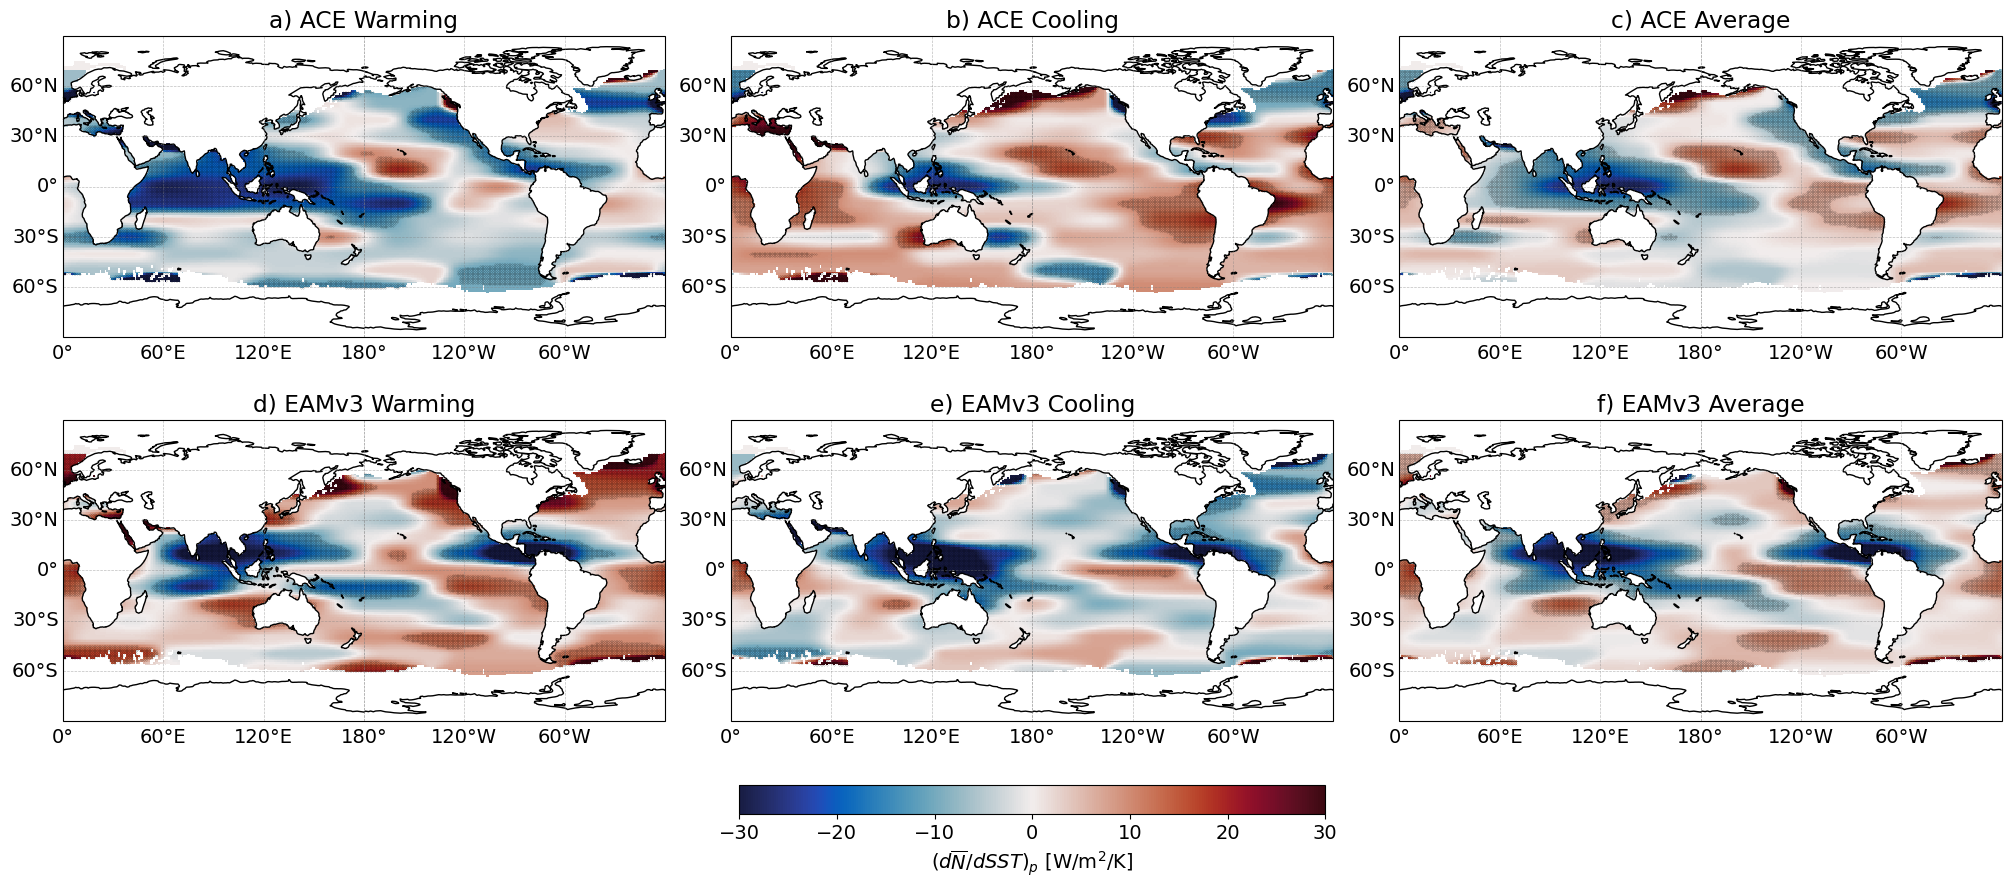

In [ ]:
plt.rcParams['font.size'] = 14
fig, axes = plt.subplots(2, 3, figsize=(20, 9), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
axes = axes.flatten()
ACE_results = [dR_dSST_warming_10yr, dR_dSST_cooling_10yr, dR_dSST_10yr]
labels = ["a) ACE Warming", "b) ACE Cooling", "c) ACE Average"]
for i in range(3):
    cf = axes[i].pcolormesh(lons, lats, ACE_results[i], vmin=-30, vmax=30, transform=ccrs.PlateCarree(), cmap=cmocean.cm.balance)
    current_sigma = sigma_p_one_sided if i < 2 else sigma_p_avg
    zscore = ACE_results[i] / current_sigma
    mask = np.where(np.abs(zscore) > 2.0, 1, np.nan)
    axes[i].scatter(lons[np.abs(zscore) > 2.0], lats[np.abs(zscore) > 2.0], s=0.02, marker="o", transform=ccrs.PlateCarree(), alpha=0.6, color="k")

    axes[i].coastlines()
    axes[i].set_global()
    axes[i].set_title(labels[i])
    gl = axes[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False

e3sm_results = [e3sm_sensitivity_warming, e3sm_sensitivity_cooling, e3sm_sensitivity]
labels = ["d) EAMv3 Warming", "e) EAMv3 Cooling", "f) EAMv3 Average"]
for i in range(3, 6):
    cf = axes[i].pcolormesh(lons, lats, e3sm_results[i-3], vmin=-30, vmax=30, transform=ccrs.PlateCarree(), cmap=cmocean.cm.balance)
    current_sigma = sigma_p_one_sided if i < 5 else sigma_p_avg
    zscore = e3sm_results[i-3] / current_sigma
    mask = np.where(np.abs(zscore) > 2.0, 1, np.nan)
    axes[i].scatter(lons[np.abs(zscore) > 2.0], lats[np.abs(zscore) > 2.0], s=0.02, marker="o", transform=ccrs.PlateCarree(), alpha=0.6, color="k")

    axes[i].coastlines()
    axes[i].set_global()
    axes[i].set_title(labels[i-3])
    gl = axes[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False    

cbar = fig.colorbar(cf, ax=axes[:], orientation="horizontal", pad=0.05, fraction=0.04)
cbar.set_label(r"$(d\overline{N}/dSST)_p$ [W/m$^2$/K]")

fig.patch.set_alpha(0.0)
fig.set_constrained_layout(True)
fig.savefig(
    "e3smv3-80levs-RS4/2025-04-30-ace-vs-e3sm-sensitivity-yr1-10-patch-20yr-control-scatter-overlay.png",
    dpi=200,
    bbox_inches="tight",
)

### Plot the difference between ACE and EAMv3 avg, with stippled regions where the difference is significant at 95% confidence level

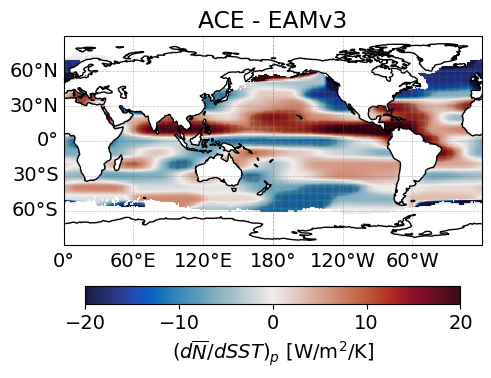

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
diff = dR_dSST_10yr - e3sm_sensitivity
cf = ax.pcolormesh(lons, lats, diff, vmin=-20, vmax=20, transform=ccrs.PlateCarree(), cmap=cmocean.cm.balance)
cbar = plt.colorbar(cf, orientation="horizontal", pad=0.15, fraction=0.07)
cbar.set_label(r"$(d\overline{N}/dSST)_p$ [W/m$^2$/K]")
zscore = diff / sigma_p_diff
mask = np.where(np.abs(zscore) > 2.0, 1, 0)
ax.scatter(lons[np.abs(zscore) > 2.0], lats[np.abs(zscore) > 2.0], s=0.01, marker="o", transform=ccrs.PlateCarree(), alpha=0.4, color="k")
ax.coastlines()
ax.set_global()
ax.set_title("ACE - EAMv3")
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False

plt.tight_layout()
fig.patch.set_alpha(0.0)
fig.savefig(
    "e3smv3-80levs-RS4/2025-04-30-ACE-E3SM-sensitivity-yr1-10-patch-20yr-control-scatter-overlay.png",
    dpi=200,
    bbox_inches="tight",
)

### Equation 4 from [Bloch‐Johnson et al. 2024](https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/2023MS003700)
$\Delta f \approx \frac{\sum_{i} \bigl(\partial f / \partial SST_{i}^{*} \bigr) a_{i} \Delta SST_{i}}{a_{tot}}$

In [26]:
historical = xr.open_dataset("/pscratch/sd/e/elynnwu/fme-output/greens-experiment-v3/pm-427/amip-1970-2020/annual_historical_ts_and_R_target_eamv3_80levs.nc")
historical_ts = historical["historical_ts"]
historical_R = historical["historical_R"]

In [27]:
historical_toa_r_anomaly = historical_R - historical_R.mean(dim="time")
historical_ts_anomaly = historical_ts - historical_ts.mean(dim="time")
historical_toa_r_anomaly = historical_toa_r_anomaly.isel(sample=0)
historical_ts_anomaly = historical_ts_anomaly.isel(sample=0)

In [28]:
historical_prediction = xr.open_dataset("/pscratch/sd/e/elynnwu/fme-output/greens-experiment-v3/beaker-RS2/amip-1970-2020/annual_historical_ts_and_R_prediction_eamv3_80levs_beaker-RS2.nc")
area_weights = np.cos(np.deg2rad(historical_prediction.lat))
historical_toa_r_pred = historical_prediction["historical_R"]
historical_toa_r_pred_anomaly = historical_toa_r_pred.isel(sample=0) - historical_toa_r_pred.isel(sample=0).mean(dim="time")
historical_toa_r_pred_anomaly = historical_toa_r_pred_anomaly * ocean_and_ice_free
historical_toa_r_pred_anomaly_global_mean = historical_toa_r_pred_anomaly.weighted(area_weights).mean(dim=["lat", "lon"])

In [38]:
deltaf_eq4_e3smv3 = np.nansum(e3sm_sensitivity.values * ocean_and_ice_free * historical_ts_anomaly.values * area, axis=(1,2)) / np.sum(area[ocean_and_ice_free])
deltaf_eq4_ace = np.nansum(dR_dSST_40yr * ocean_and_ice_free * historical_ts_anomaly.values * area, axis=(1,2)) / np.sum(area[ocean_and_ice_free])

In [30]:
area_weights = np.cos(np.deg2rad(historical.lat))
historical_ts_anomaly_global_mean = historical_ts_anomaly.weighted(area_weights).mean(dim=["lat", "lon"])
historical_toa_r_anomaly = historical_toa_r_anomaly * ocean_and_ice_free
historical_toa_r_anomaly_global_mean = historical_toa_r_anomaly.weighted(area_weights).mean(dim=["lat", "lon"])

<xarray.DataArray 'historical_R' ()> Size: 8B
array(0.42903716) <xarray.DataArray 'historical_R' ()> Size: 8B
array(0.33895297)
0.6255504 0.32372161661424137 0.6643364832123958


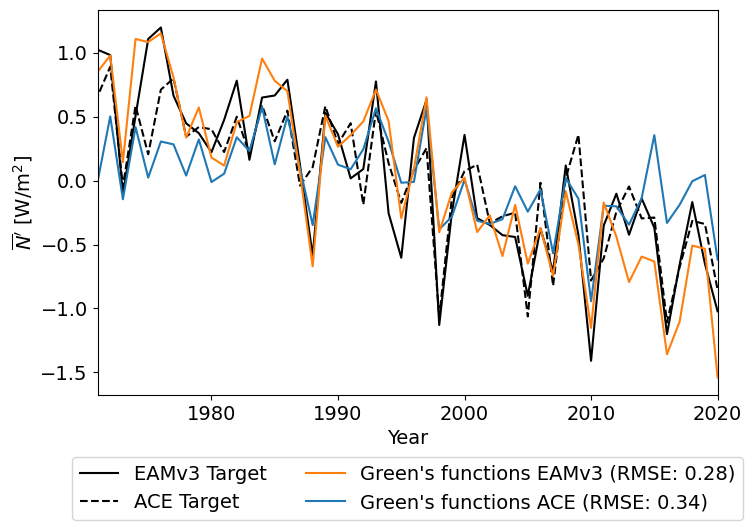

In [ ]:
num_years = 51
times=[i for i in range(1970,1970+num_years)]
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

target_eamv3, = ax.plot(times, historical_toa_r_anomaly_global_mean, color="k", label="EAMv3 Target")
target_ace, = ax.plot(times, historical_toa_r_pred_anomaly_global_mean, color="k", label="ACE Target", ls="--")
rmse_ace = np.sqrt(np.mean((deltaf_eq4_ace - historical_toa_r_anomaly_global_mean) ** 2))
rmse_ace_ace = np.sqrt(np.mean((deltaf_eq4_ace - historical_toa_r_pred_anomaly_global_mean) ** 2))
print(rmse_ace, rmse_ace_ace)
predicted_ace, = ax.plot(times, deltaf_eq4_ace, label=f"Green's functions ACE (RMSE: {rmse_ace_ace:.2f})", color="tab:blue")
rmse_e3smv3 = np.sqrt(np.mean((deltaf_eq4_e3smv3 - historical_toa_r_anomaly_global_mean) ** 2))
predicted_eamv3, = ax.plot(times, deltaf_eq4_e3smv3, label=f"Green's functions EAMv3 (RMSE: {rmse_e3smv3:.2f})", color="tab:orange")
ax.set_xlabel("Year")
ax.set_ylabel(r"$\overline{N}'$ [W/m$^2$]")
handles = [target_eamv3, target_ace, predicted_eamv3, predicted_ace]
labels = [h.get_label() for h in handles]
ax.legend(handles, labels, ncol=2, loc="lower center", bbox_to_anchor=(0.5, -0.35))
ax.set_xlim(1971, 2020)
print(np.std(historical_toa_r_anomaly_global_mean.values), np.std(deltaf_eq4_ace), np.std(deltaf_eq4_e3smv3))
ax.set_facecolor("white")
fig.patch.set_alpha(0.0)
fig.savefig(
    "e3smv3-80levs/2025-04-21-historical-reconstruction-of-net-TOA-radiation-40yr-ACE.png",
    dpi=200,
    bbox_inches="tight",
)